# 1. Setup the environment

Load libraries

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
import seaborn as sns
from sdv.metadata import Metadata
from sdv.single_table  import CTGANSynthesizer
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import ks_2samp
import numpy as np
import functions as ff


Load data

In [180]:
pos_real_data = "data/real_data.csv"
real_data = pd.read_csv(pos_real_data)

# 2. Explorative Data Analysis (EDA)

Shape

In [181]:
print("Shape:", real_data.shape)

Shape: (1000, 21)


In [182]:
real_data.shape[0]*real_data.shape[1]

21000

In [183]:
real_data.isnull().values.sum()

np.int64(3481)

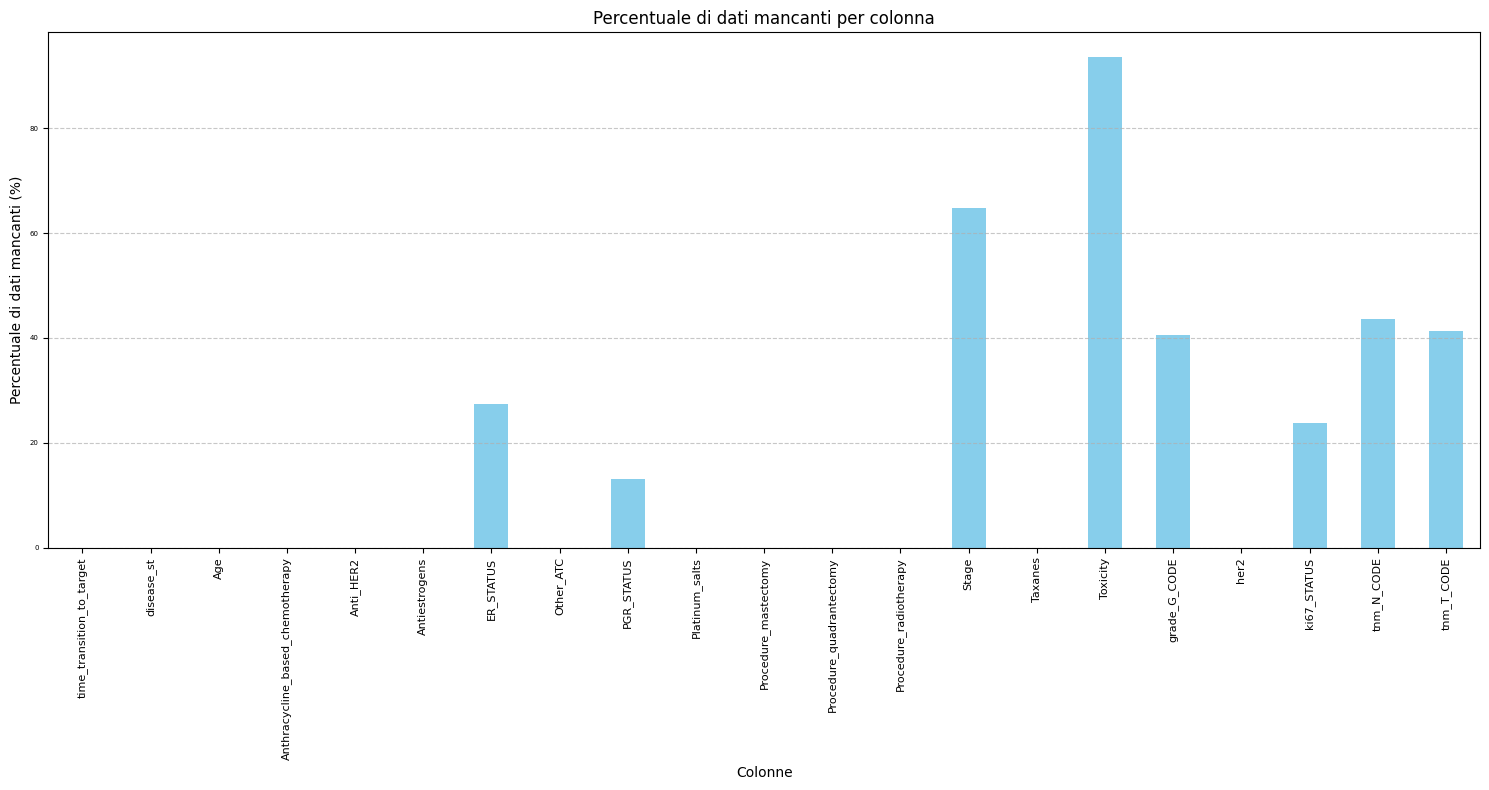

In [185]:
plot_missing_data_histogram(real_data)

In [186]:
real_data

,time_transition_to_target,disease_st,Age,Anthracycline_based_chemotherapy,Anti_HER2,Antiestrogens,ER_STATUS,Other_ATC,PGR_STATUS,Platinum_salts,...,Procedure_quadrantectomy,Procedure_radiotherapy,Stage,Taxanes,Toxicity,grade_G_CODE,her2,ki67_STATUS,tnm_N_CODE,tnm_T_CODE
0,3864,censored,60-70,yes,no,yes,negative,no,negative,no,...,done,no,NaN,yes,NaN,NaN,negative,high,NaN,NaN
1,69,censored,50-60,no,no,no,negative,no,negative,no,...,done,no,NaN,no,NaN,NaN,positive,high,NaN,NaN
2,4156,censored,60-70,yes,no,no,negative,no,negative,no,...,done,no,stage 2,yes,G3,G3,negative,high,N1,T2
3,1400,censored,20-40,no,no,yes,positive,no,positive,no,...,no,no,NaN,no,NaN,G3,positive,high,N2,T2
4,1249,death,60-70,yes,yes,no,negative,no,negative,no,...,done,yes,stage 1,yes,NaN,G3,negative,high,N0,T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3740,death,60-70,yes,yes,no,NaN,no,positive,no,...,done,yes,stage 1,yes,NaN,G2,positive,NaN,N0,T1
996,1983,censored,50-60,no,no,no,NaN,no,negative,no,...,no,yes,stage 1,no,NaN,G3,negative,high,N0,T1
997,1860,censored,60-70,no,no,no,negative,no,negative,no,...,no,yes,NaN,no,NaN,NaN,positive,high,NaN,NaN
998,1611,censored,60-70,yes,no,no,negative,no,negative,no,...,no,yes,NaN,yes,NaN,NaN,negative,high,N0,T1


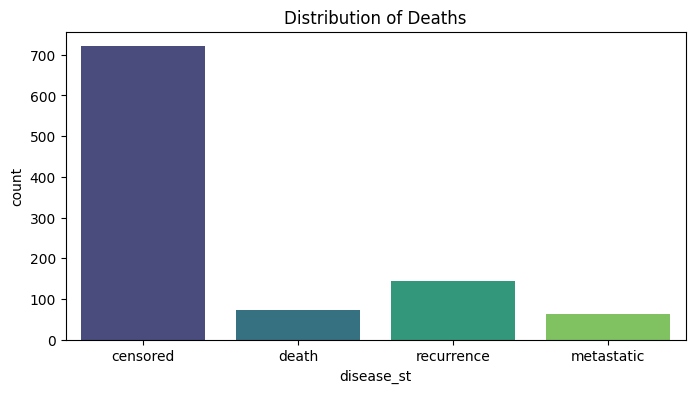

In [188]:
plt.figure(figsize=(8,4))
sns.countplot(data=real_data, x="disease_st", palette="viridis")
plt.title("Distribution of Deaths")
plt.show()

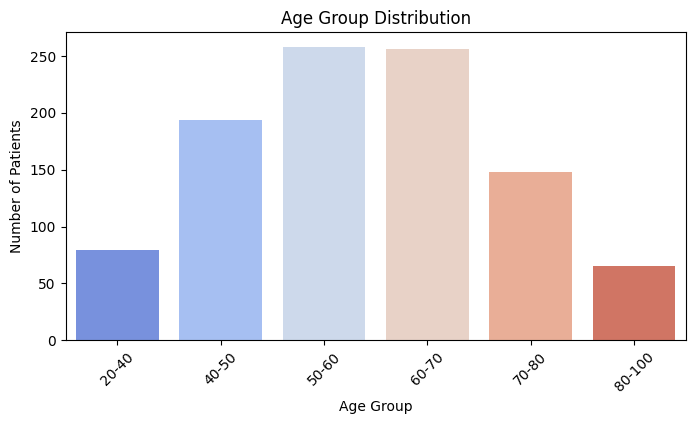

In [189]:
plt.figure(figsize=(8,4))
sns.countplot(data=real_data, x="Age", order=sorted(real_data["Age"].unique()), palette="coolwarm")
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.show()

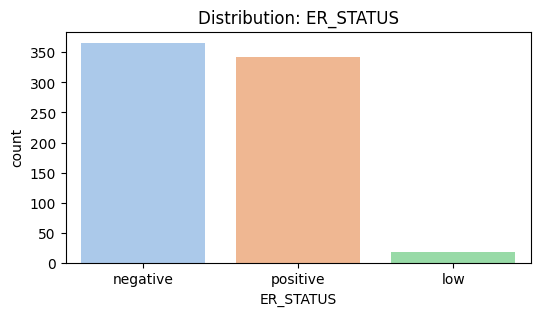

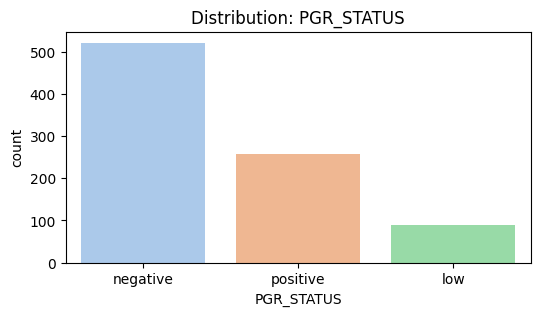

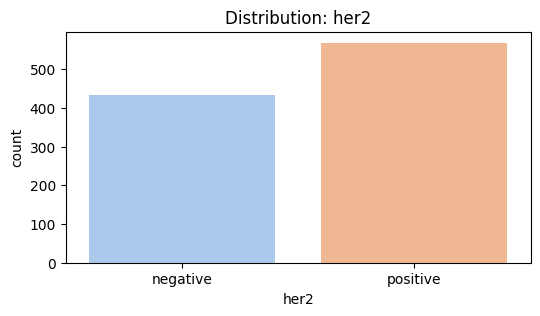

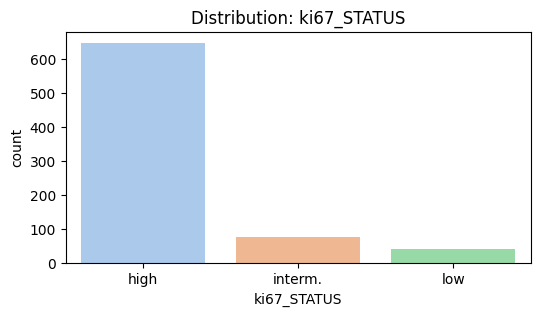

In [190]:

# Receptor status
for col in ["ER_STATUS", "PGR_STATUS", "her2", "ki67_STATUS"]:
    plt.figure(figsize=(6,3))
    sns.countplot(data=real_data, x=col, palette="pastel")
    plt.title(f"Distribution: {col}")
    plt.show()


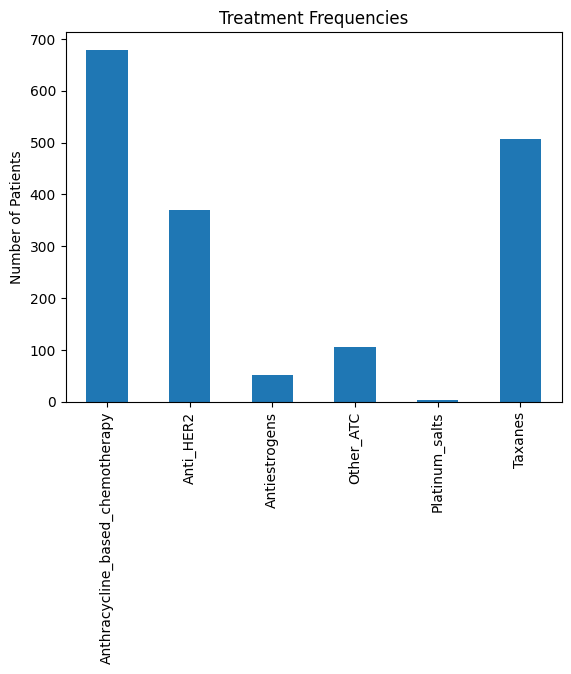

In [191]:
# Convert treatment columns to 0/1 if they are not numeric
treatments = ["Anthracycline_based_chemotherapy", "Anti_HER2", "Antiestrogens", "Other_ATC", "Platinum_salts", "Taxanes"]

# # Preview unique values to understand encoding
# for col in treatments:
#     print(f"{col}: {real_data[col].unique()}")

# Example: if values are 'yes'/'no', convert them
temp_treat=real_data[treatments] 
temp_treat = temp_treat.apply(lambda col: col.map({'yes': 1, 'no': 0}))

# Plot treatment frequencies
temp_treat.sum().plot(kind="bar", title="Treatment Frequencies", ylabel="Number of Patients")
plt.show()


Procedure_mastectomy: ['no' 'done']
Procedure_quadrantectomy: ['done' 'no']
Procedure_radiotherapy: ['no' 'yes']


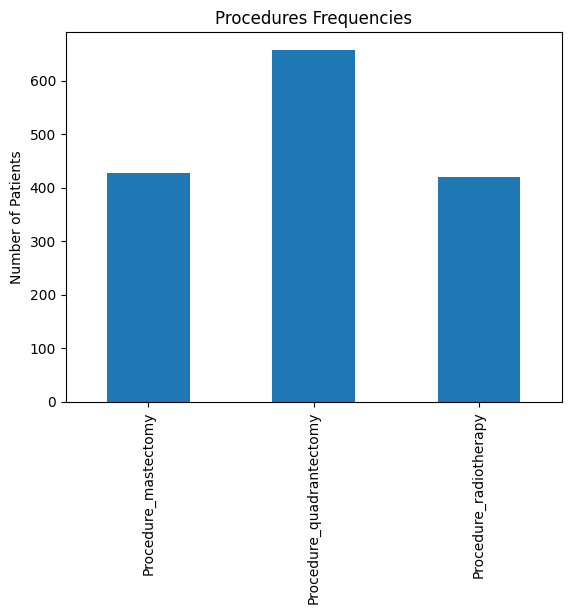

In [192]:
# #  Procedures

# Convert procedures columns to 0/1 if they are not numeric
procedures = ["Procedure_mastectomy", "Procedure_quadrantectomy", "Procedure_radiotherapy"]

# Preview unique values to understand encoding
for col in procedures:
    print(f"{col}: {real_data[col].unique()}")

# Example: if values are 'done'/'no', convert them
temp_proc=real_data[procedures] 

temp_proc[["Procedure_mastectomy", "Procedure_quadrantectomy"]] = temp_proc[["Procedure_mastectomy", "Procedure_quadrantectomy"]].apply(lambda col: col.map({'done': 1, 'no': 0}))
temp_proc[["Procedure_radiotherapy"]] = temp_proc[["Procedure_radiotherapy"]].apply(lambda col: col.map({'yes': 1, 'no': 0}))

# Plot procedures frequencies
temp_proc.sum().plot(kind="bar", title="Procedures Frequencies", ylabel="Number of Patients")
plt.show()


# 3. Data preparation

Mapping columns

In [193]:
real_data

,time_transition_to_target,disease_st,Age,Anthracycline_based_chemotherapy,Anti_HER2,Antiestrogens,ER_STATUS,Other_ATC,PGR_STATUS,Platinum_salts,...,Procedure_quadrantectomy,Procedure_radiotherapy,Stage,Taxanes,Toxicity,grade_G_CODE,her2,ki67_STATUS,tnm_N_CODE,tnm_T_CODE
0,3864,censored,60-70,yes,no,yes,negative,no,negative,no,...,done,no,NaN,yes,NaN,NaN,negative,high,NaN,NaN
1,69,censored,50-60,no,no,no,negative,no,negative,no,...,done,no,NaN,no,NaN,NaN,positive,high,NaN,NaN
2,4156,censored,60-70,yes,no,no,negative,no,negative,no,...,done,no,stage 2,yes,G3,G3,negative,high,N1,T2
3,1400,censored,20-40,no,no,yes,positive,no,positive,no,...,no,no,NaN,no,NaN,G3,positive,high,N2,T2
4,1249,death,60-70,yes,yes,no,negative,no,negative,no,...,done,yes,stage 1,yes,NaN,G3,negative,high,N0,T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3740,death,60-70,yes,yes,no,NaN,no,positive,no,...,done,yes,stage 1,yes,NaN,G2,positive,NaN,N0,T1
996,1983,censored,50-60,no,no,no,NaN,no,negative,no,...,no,yes,stage 1,no,NaN,G3,negative,high,N0,T1
997,1860,censored,60-70,no,no,no,negative,no,negative,no,...,no,yes,NaN,no,NaN,NaN,positive,high,NaN,NaN
998,1611,censored,60-70,yes,no,no,negative,no,negative,no,...,no,yes,NaN,yes,NaN,NaN,negative,high,N0,T1


In [194]:
baseline_covariates_direct = {
    'ER_STATUS': {'negative': 0, 'low': 1, 'positive': 2},
    'PGR_STATUS': {'negative': 0, 'low': 1, 'positive': 2},
    'ki67_STATUS': {'low': 1, 'interm.': 2, 'high': 3},
    'her2': {'positive': 1, 'negative': 0},
    'tnm_N_CODE': {'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3},
    'tnm_T_CODE': {'T0': 0, 'TIS': 1, 'T1': 2, 'T2': 3, 'T3': 4, 'T4': 5},
    'grade_G_CODE': {'G1': 1, 'G2': 2, 'G3': 3},
    'Procedure_mastectomy': {'no': 0, 'done': 1},
    'Procedure_quadrantectomy': {'no': 0, 'done': 1},
    'Procedure_radiotherapy': {'no': 0, 'yes': 1},
    'Anthracycline_based_chemotherapy': {'no': 0, 'yes': 1},
    'Anti_HER2': {'no': 0, 'yes': 1},
    'Taxanes': {'no': 0, 'yes': 1},
    'Platinum_salts': {'no': 0, 'yes': 1},
    'Antiestrogens': {'no': 0, 'yes': 1},
    'Stage': {'stage 1': 1, 'stage 2': 2, 'stage 3': 3, 'stage 4': 4},
    'Other_ATC': {'no': 0, 'yes': 1},
    'Toxicity': { 'G1': 1, 'G2': 2, 'G3': 3, 'G4': 4},
    'grade_G_CODE': {'G1': 1, 'G2': 2, 'G3': 3},
    'Age': {'20-40': 1, '40-50': 2, '50-60': 3, '60-70': 4, '70-80': 5, '80-100': 6},
    'disease_st': {'censored': 0, 'recurrence': 1, 'metastatic': 2, 'death': 3}

}


for col, mapping in baseline_covariates_direct.items():
        real_data[col] = real_data[col].map(mapping)


real_data.head()


,time_transition_to_target,disease_st,Age,Anthracycline_based_chemotherapy,Anti_HER2,Antiestrogens,ER_STATUS,Other_ATC,PGR_STATUS,Platinum_salts,...,Procedure_quadrantectomy,Procedure_radiotherapy,Stage,Taxanes,Toxicity,grade_G_CODE,her2,ki67_STATUS,tnm_N_CODE,tnm_T_CODE
0,3864,0,4,1,0,1,0.0,0,0.0,0,...,1,0,NaN,1,NaN,NaN,0,3.0,NaN,NaN
1,69,0,3,0,0,0,0.0,0,0.0,0,...,1,0,NaN,0,NaN,NaN,1,3.0,NaN,NaN
2,4156,0,4,1,0,0,0.0,0,0.0,0,...,1,0,2.0,1,3.0,3.0,0,3.0,1.0,3.0
3,1400,0,1,0,0,1,2.0,0,2.0,0,...,0,0,NaN,0,NaN,3.0,1,3.0,2.0,3.0
4,1249,3,4,1,1,0,0.0,0,0.0,0,...,1,1,1.0,1,NaN,3.0,0,3.0,0.0,2.0


In [ ]:
# OPTIONAL ->included in sdv library for generation
# from sklearn.preprocessing import MinMaxScaler
# cont_cols=['time_transition_to_target']
# scaler=MinMaxScaler()
# real_data[cont_cols]=scaler.fit_transform(real_data[cont_cols])


In [195]:
real_data

,time_transition_to_target,disease_st,Age,Anthracycline_based_chemotherapy,Anti_HER2,Antiestrogens,ER_STATUS,Other_ATC,PGR_STATUS,Platinum_salts,...,Procedure_quadrantectomy,Procedure_radiotherapy,Stage,Taxanes,Toxicity,grade_G_CODE,her2,ki67_STATUS,tnm_N_CODE,tnm_T_CODE
0,3864,0,4,1,0,1,0.0,0,0.0,0,...,1,0,NaN,1,NaN,NaN,0,3.0,NaN,NaN
1,69,0,3,0,0,0,0.0,0,0.0,0,...,1,0,NaN,0,NaN,NaN,1,3.0,NaN,NaN
2,4156,0,4,1,0,0,0.0,0,0.0,0,...,1,0,2.0,1,3.0,3.0,0,3.0,1.0,3.0
3,1400,0,1,0,0,1,2.0,0,2.0,0,...,0,0,NaN,0,NaN,3.0,1,3.0,2.0,3.0
4,1249,3,4,1,1,0,0.0,0,0.0,0,...,1,1,1.0,1,NaN,3.0,0,3.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3740,3,4,1,1,0,NaN,0,2.0,0,...,1,1,1.0,1,NaN,2.0,1,NaN,0.0,2.0
996,1983,0,3,0,0,0,NaN,0,0.0,0,...,0,1,1.0,0,NaN,3.0,0,3.0,0.0,2.0
997,1860,0,4,0,0,0,0.0,0,0.0,0,...,0,1,NaN,0,NaN,NaN,1,3.0,NaN,NaN
998,1611,0,4,1,0,0,0.0,0,0.0,0,...,0,1,NaN,1,NaN,NaN,0,3.0,0.0,2.0


IMPUTATION

In [196]:
cols_to_impute = real_data.columns[real_data.isnull().any()].tolist()

In [199]:
print(cols_to_impute)

['ER_STATUS', 'PGR_STATUS', 'Stage', 'Toxicity', 'grade_G_CODE', 'ki67_STATUS', 'tnm_N_CODE', 'tnm_T_CODE']


In [197]:
print("KNN imputation")
imputer = KNNImputer(n_neighbors=2)
real_data[cols_to_impute] = imputer.fit_transform(real_data[cols_to_impute])

for col in baseline_covariates_direct.keys():
    real_data[col] = pd.Series(real_data[col]).astype('int')

KNN imputation


In [198]:
real_data.head()

,time_transition_to_target,disease_st,Age,Anthracycline_based_chemotherapy,Anti_HER2,Antiestrogens,ER_STATUS,Other_ATC,PGR_STATUS,Platinum_salts,...,Procedure_quadrantectomy,Procedure_radiotherapy,Stage,Taxanes,Toxicity,grade_G_CODE,her2,ki67_STATUS,tnm_N_CODE,tnm_T_CODE
0,3864,0,4,1,0,1,0,0,0,0,...,1,0,1,1,2,3,0,3,0,2
1,69,0,3,0,0,0,0,0,0,0,...,1,0,1,0,2,3,1,3,0,2
2,4156,0,4,1,0,0,0,0,0,0,...,1,0,2,1,3,3,0,3,1,3
3,1400,0,1,0,0,1,2,0,2,0,...,0,0,2,0,2,3,1,3,2,3
4,1249,3,4,1,1,0,0,0,0,0,...,1,1,1,1,4,3,0,3,0,2


In [200]:
cols_discrete = real_data.drop(['time_transition_to_target'], axis=1).columns

# 4. Generative model

In [201]:
metadata=Metadata.detect_from_dataframe(real_data)

In [ ]:
print(metadata)

TRAINING GENERATIVE MODEL

In [204]:
synthetizer=CTGANSynthesizer(metadata,epochs=30, verbose=True)
synthetizer.fit(real_data)


Gen. (0.03) | Discrim. (0.22): 100%|██████████| 30/30 [00:18<00:00,  1.65it/s]  


GENERATION

In [205]:
synth_data=synthetizer.sample(3000)

EVALUATION

In [206]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(real_data, synth_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(real_data, synth_data, metadata)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 21/21 [00:00<00:00, 1386.70it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 208.68it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 21/21 [00:00<00:00, 565.32it/s]|
Column Shapes Score: 92.43%

(2/2) Evaluating Column Pair Trends: |██████████| 210/210 [00:00<00:00, 289.88it/s]|
Column Pair Trends Score: 86.26%

Overall Score (Average): 89.34%



Re-transform data for better visual evaluation

In [ ]:
# IF cont columns were scaled
# synth_data[cont_cols]=scaler.inverse_transform(synth_data[cont_cols])
# real_data[cont_cols]=scaler.inverse_transform(real_data[cont_cols])

In [ ]:
baseline_covariates_inverse = {
    key: {v: k for k, v in value.items()} for key, value in baseline_covariates_direct.items()
}

for col, mapping in baseline_covariates_inverse.items():
        real_data[col] = real_data[col].map(mapping)
        synth_data[col] = synth_data[col].map(mapping)
        

In [213]:

def tvd(p, q):
    """
    Compute the Total Variation Distance between two probability distributions p and q.
    """
    return 0.5 * np.sum(np.abs(p - q))

def compare_real_vs_synth(real_data, synth_data):
    """
    Compare variable distributions between real and synthetic datasets.
    
    - For continuous variables: uses KDE plots and the Kolmogorov-Smirnov test.
    - For categorical variables: calculates Total Variation Distance (TVD) and bar plots.

    Args:
        real_data (pd.DataFrame): Real dataset
        synth_data (pd.DataFrame): Synthetic dataset
    """
    for col in real_data.columns:
        print(f"\nVariable: {col}")

        fig, ax = plt.subplots(figsize=(6, 4))

        # Continuous variable (numerical with enough unique values)
        if real_data[col].dtype in [np.float64, np.int64] and real_data[col].nunique() > 10:
            sns.kdeplot(real_data[col].dropna(), label="Real", ax=ax)
            sns.kdeplot(synth_data[col].dropna(), label="Synthetic", ax=ax)
            ax.set_title(f"Distribution of {col}")
            ax.legend()

            # Kolmogorov-Smirnov test
            stat, pval = ks_2samp(real_data[col].dropna(), synth_data[col].dropna())
            print(f"KS test p-value = {pval:.4f}")

        # Categorical or discrete variable
        else:
            real_counts = real_data[col].value_counts(normalize=True)
            synth_counts = synth_data[col].value_counts(normalize=True)

            all_categories = set(real_counts.index).union(set(synth_counts.index))

            # Align indices
            real_counts = real_counts.reindex(all_categories, fill_value=0)
            synth_counts = synth_counts.reindex(all_categories, fill_value=0)

            tvd_value = tvd(real_counts, synth_counts)
            print(f"Total Variation Distance (TVD) = {tvd_value:.4f}")

            df_cat = pd.DataFrame({'Real': real_counts, 'Synthetic': synth_counts})
            df_cat.plot(kind='bar', ax=ax, title=f"Distribution of {col}")
            ax.set_ylabel("Normalized Frequency")

        plt.tight_layout()
        plt.show()


Variable: time_transition_to_target
KS test p-value = 0.0000


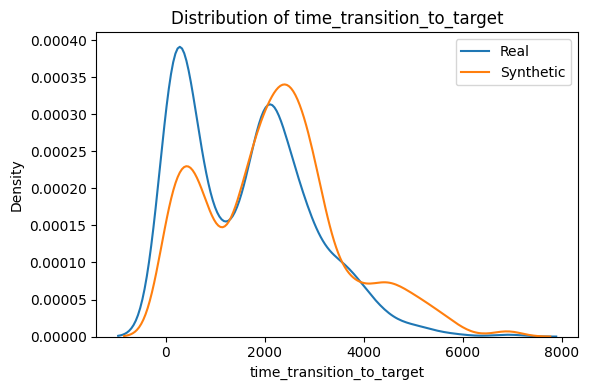


Variable: disease_st
Total Variation Distance (TVD) = 0.1063


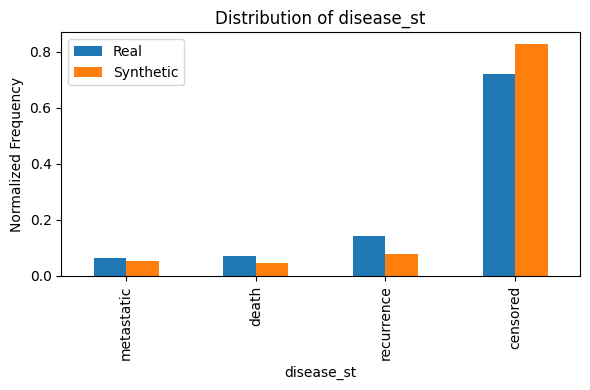


Variable: Age
Total Variation Distance (TVD) = 0.1107


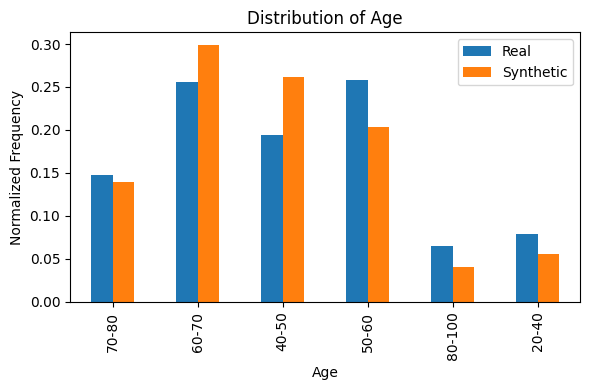


Variable: Anthracycline_based_chemotherapy
Total Variation Distance (TVD) = 0.1780


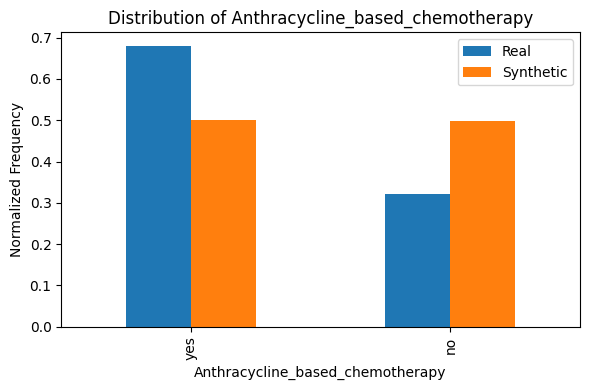


Variable: Anti_HER2
Total Variation Distance (TVD) = 0.0677


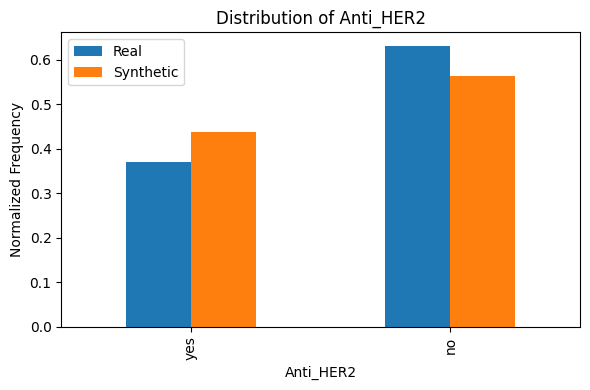


Variable: Antiestrogens
Total Variation Distance (TVD) = 0.0023


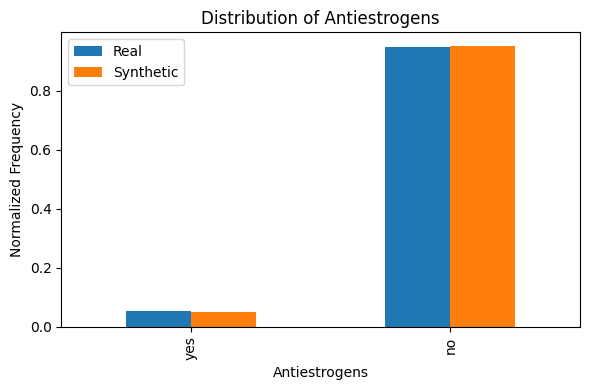


Variable: ER_STATUS
Total Variation Distance (TVD) = 0.0547


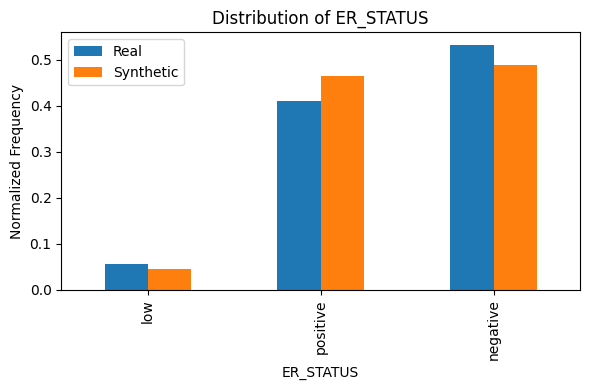


Variable: Other_ATC
Total Variation Distance (TVD) = 0.0160


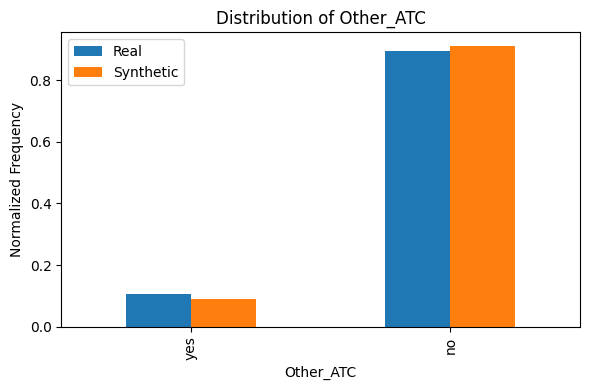


Variable: PGR_STATUS
Total Variation Distance (TVD) = 0.1853


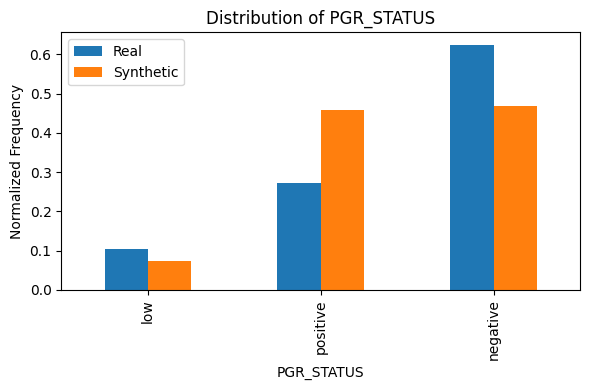


Variable: Platinum_salts
Total Variation Distance (TVD) = 0.0160


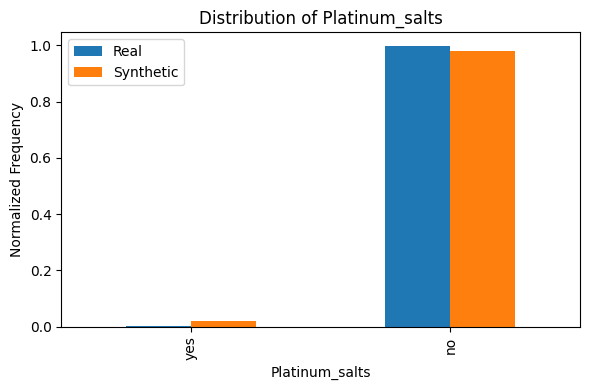


Variable: Procedure_mastectomy
Total Variation Distance (TVD) = 0.0637


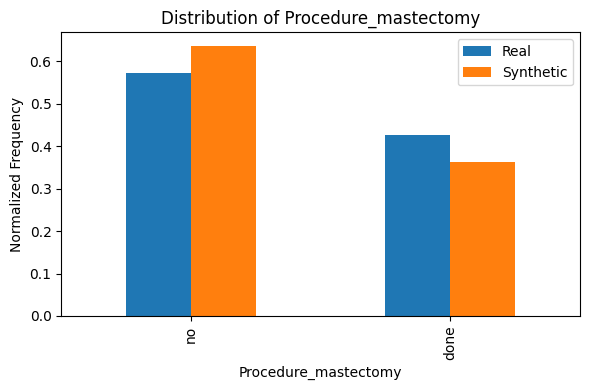


Variable: Procedure_quadrantectomy
Total Variation Distance (TVD) = 0.0960


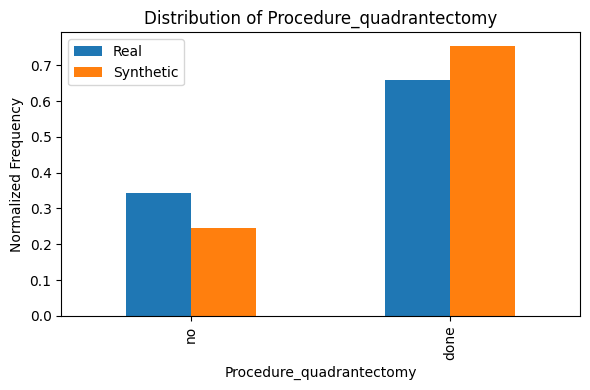


Variable: Procedure_radiotherapy
Total Variation Distance (TVD) = 0.0183


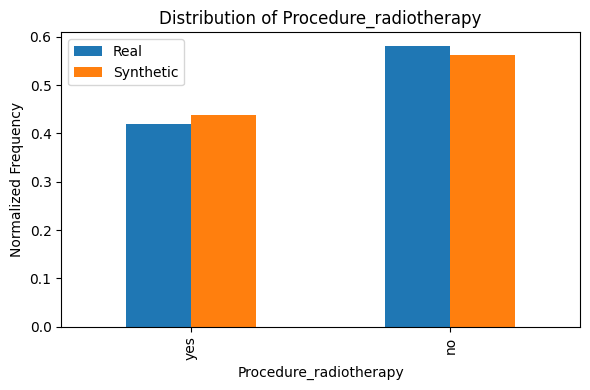


Variable: Stage
Total Variation Distance (TVD) = 0.0217


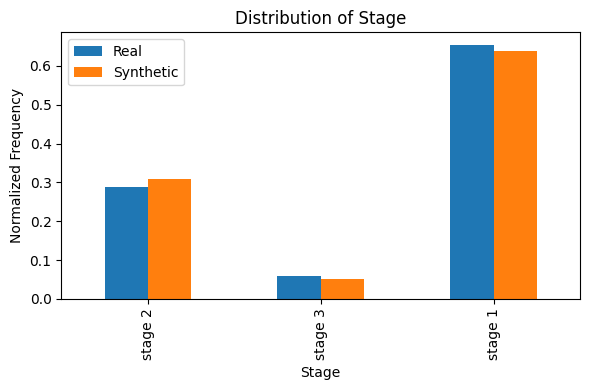


Variable: Taxanes
Total Variation Distance (TVD) = 0.1197


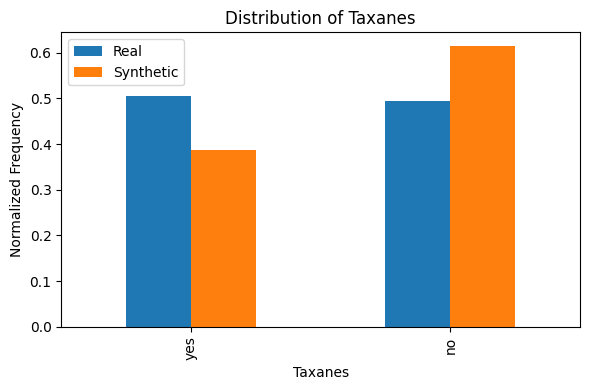


Variable: Toxicity
Total Variation Distance (TVD) = 0.0880


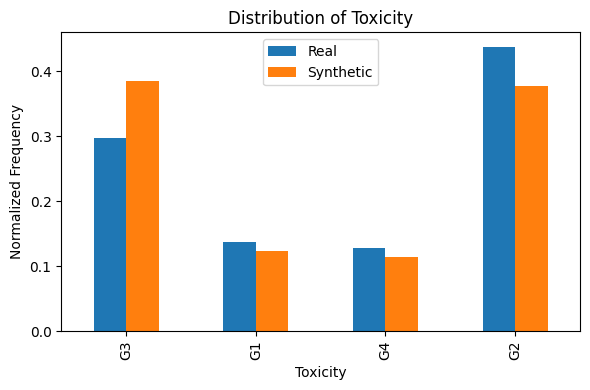


Variable: grade_G_CODE
Total Variation Distance (TVD) = 0.2057


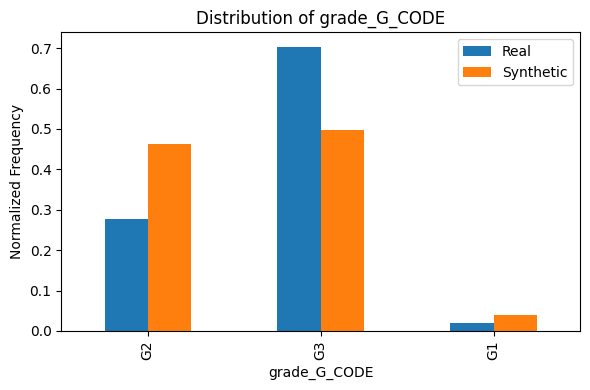


Variable: her2
Total Variation Distance (TVD) = 0.0063


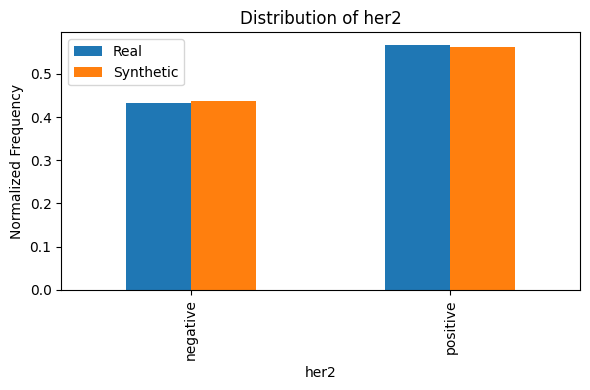


Variable: ki67_STATUS
Total Variation Distance (TVD) = 0.0140


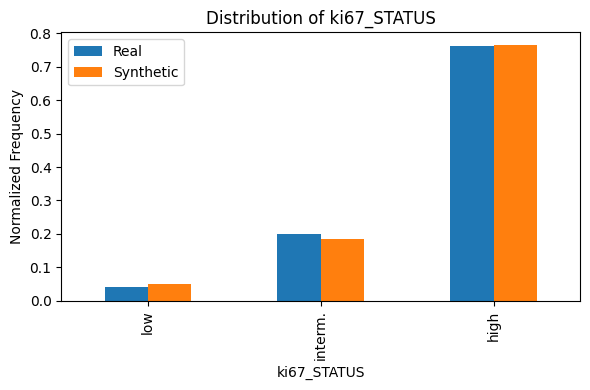


Variable: tnm_N_CODE
Total Variation Distance (TVD) = 0.0170


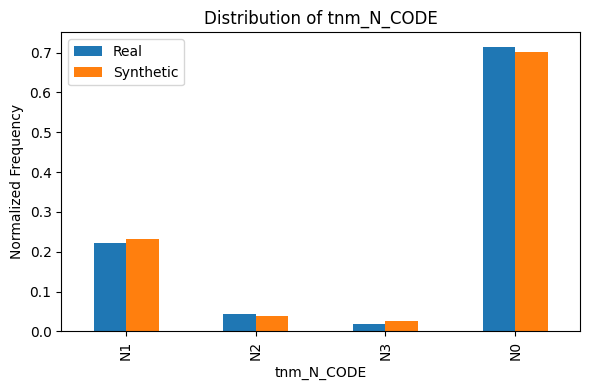


Variable: tnm_T_CODE
Total Variation Distance (TVD) = 0.0233


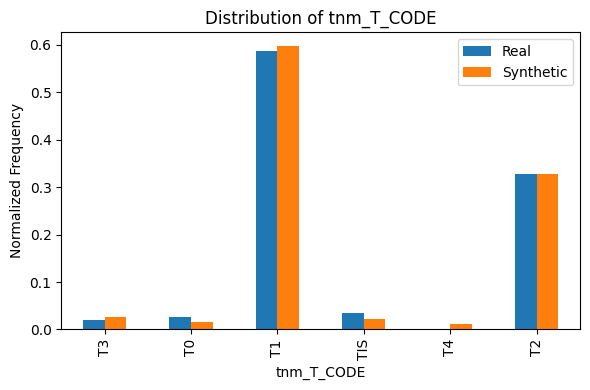

In [214]:
compare_real_vs_synth(real_data, synth_data)

*good fidelity!*

Overall survival

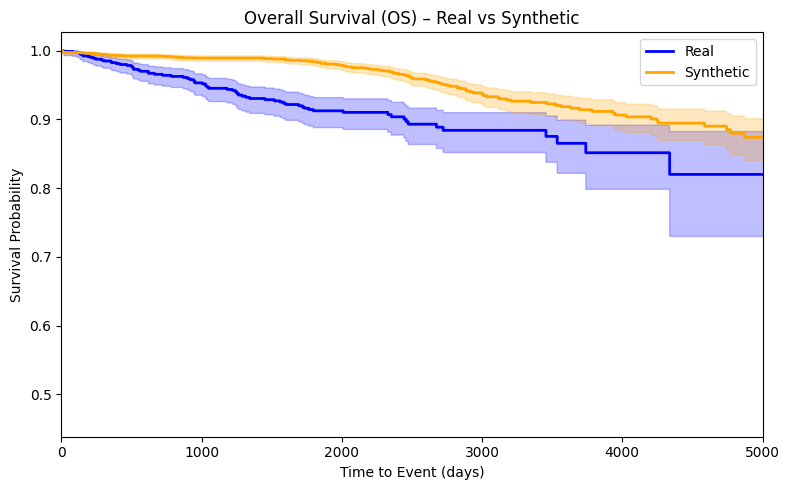

In [218]:
# === Prepare the data ===

# Synthetic data:
synth_data['OS_event'] = synth_data['disease_st'].isin(['death']).astype(int)
synth_data['OS_time'] = synth_data['time_transition_to_target']

# Real data:
real_data['OS_event'] = real_data['disease_st'].isin(['death']).astype(int)
real_data['OS_time'] = real_data['time_transition_to_target']

# === Kaplan-Meier fitting ===

# Instantiate Kaplan-Meier estimators
kmf_real = KaplanMeierFitter()
kmf_synth = KaplanMeierFitter()

# Fit KM model for real data
kmf_real.fit(
    durations=real_data['OS_time'],         # time to event or censoring
    event_observed=real_data['OS_event'],   # 1 = event occurred, 0 = censored
    label="Real"                            # label for the plot legend
)

# Fit KM model for synthetic data
kmf_synth.fit(
    durations=synth_data['OS_time'],
    event_observed=synth_data['OS_event'],
    label="Synthetic"
)

# === Plot Kaplan-Meier curves ===

plt.figure(figsize=(8, 5))  # Set figure size

# Plot KM curve for real data
kmf_real.plot(ci_show=True, lw=2, color='blue')  # Show confidence interval

# Plot KM curve for synthetic data
kmf_synth.plot(ci_show=True, lw=2, color='orange')


# Add plot title and labels
plt.xlim(0, 5000)
plt.title("Overall Survival (OS) – Real vs Synthetic")
plt.xlabel("Time to Event (days)")
plt.ylabel("Survival Probability")
plt.legend()       # Show legend
plt.tight_layout() # Prevent label cutoff
plt.show()         # Display the plot



Disease Free Survival

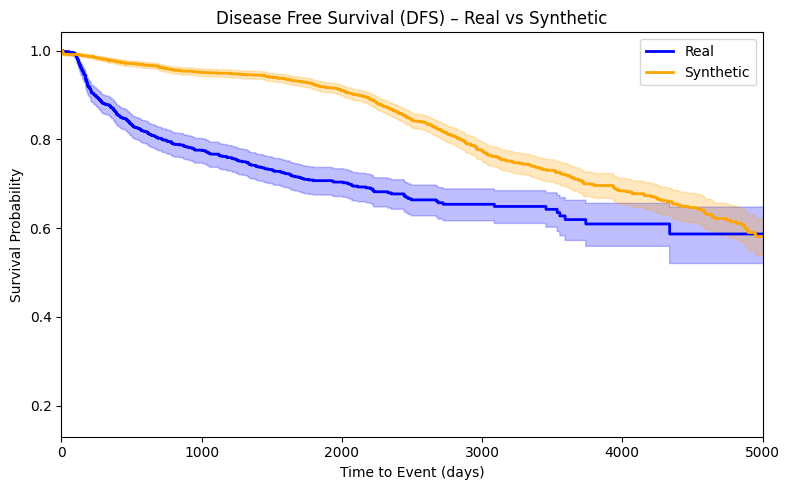

In [220]:

synth_data['DFS_event'] = synth_data['disease_st'].isin([ 'death', 'metastatic', 'recurrence']).astype(int)
synth_data['DFS_time'] = synth_data['time_transition_to_target']


real_data['DFS_event'] = real_data['disease_st'].isin(['death', 'metastatic', 'recurrence']).astype(int)
real_data['DFS_time'] = real_data['time_transition_to_target']

kmf_real = KaplanMeierFitter()
kmf_synth = KaplanMeierFitter()

kmf_real.fit(durations=real_data['DFS_time'], event_observed=real_data['DFS_event'], label="Real")
kmf_synth.fit(durations=synth_data['DFS_time'], event_observed=synth_data['DFS_event'], label="Synthetic")

# === Plot ===
plt.figure(figsize=(8, 5))
kmf_real.plot(ci_show=True, lw=2, color='blue')
kmf_synth.plot(ci_show=True, lw=2, color='orange')

plt.xlim(0, 5000)
plt.title("Disease Free Survival (DFS) – Real vs Synthetic")
plt.xlabel("Time to Event (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.show()



*bad utility!*